# Fintech Python 数据采集、处理、分析以及机器学习

## 预备知识

1. python3.0以上基础 [https://www.python.org](https://www.python.org)
2. python http访问库，[requests](http://www.python-requests.org/en/master/)
3. python html解析库，[Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/)
4. python 数据处理库，[Pandas](https://pandas.pydata.org)
5. python 绘图工具库，[Matplotlib](https://matplotlib.org)
6. machine learning， [Tensorflow](https://www.tensorflow.org)
7. web&http基本概念和原理  

以上的工具库或者开源项目，大家在学习的时候，其实只需要关注其基本概念和原理以及官方文档的前几章，在后面的课程中我们会一步一步边上课边讲解。

## 课程题目简介
通过本课程，我们将去探索人民币汇率和国内油价是否存在某种关系。    
同时用机器学习的方法去给这种关系建立模型，并通过这个模型给出一个汇率，从而简单预测国内油价。    
该课程建立的模型仅仅是为了介绍方法，大家也知道强扭的瓜不甜，这个模型或许就是错误的，重要的是获取这个结果，我们使用了什么样的方法。

## web和http基本概念
web - World Wide Web，万维网    
http - hyper text transfer protocol 超文本传输协议    
**计算机连接  ->  所有设备的连接  ->  人的连接**

## 数据采集
这部分我们将探索如何使用python这门语言以及其提供的开源项目去抓取目标数据。    
主要分为两个部分： 
* 人民币汇率数据的抓取  
* 国内油价数据的抓取

### 人民币汇率数据的抓取
数据来源，中国银行外汇牌价 [中国银行](http://www.boc.cn/sourcedb/whpj/)

#### 汇率数据的网页结构分析
该页面提供了一个根据起始时间和结束时间以及外币币种的搜索操作，我们根据此操作获取2012-1-1至2018-10-1之间的人民币和美元的汇率数据。    
本课程选择 *现钞卖出价* 作为目标数据。 
经过分析可以得出实际的获取url为: http://srh.bankofchina.com/search/whpj/search.jsp?erectDate=2018-10-01%2020:00:00&nothing=2018-10-02%2021:00:00&pjname=1316    
其中erectDate为开始时间，nothing为结束时间，pjname为外汇类型(1316为美元)。
开始时间和结束时间虽然在界面上通过ui操作只能生成日为单位的时间，但是经过尝试，发现可以接受带时分秒的参数。在上述的url中带了时分秒，其中%20是经过url编码的空格。    
如果起始时间设置为2012-01-01，结束时间设置为2018010-01，则search结果为一个分页的数据列表，大概每天的数据为3页，而我们的目标是每天一个汇率数据即可，我们选择每天00:00:00-23:59:59之间的第一条数据作为当日数据。    

**那接下来我们是分页去获取数据，还是采用别的方式呢？大家这里可以思考一下。**


#### 汇率数据的抓取
基于上一节的分析，我们准备每次抓取数据都构建如下的http请求:    
- url:  http://srh.bankofchina.com/search/whpj/search.jsp
- method: GET
- query string:   
   - erectDate 起始时间 2018-10-01 09:00:00
   - nothing   结束时间 2018-10-01 10:00:00
   - pjname    1316
- user agent: 随机列表选择

每次获取返回列表的第一条数据作为当日数据。

#### 汇率数据的提取和清洗
汇率数据我们抓取之后存储为csv格式：    
`day,price`    
每一行存储一个数据，分别是日期、汇率价格。    

#### 代码:

In [16]:
# import requests
# import random
# import datetime
# from bs4 import BeautifulSoup

# user_agents = [
#     'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
#     'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
#     'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/11.1.2 Safari/605.1.15',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/11.1 Safari/605.1.15',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2) AppleWebKit/604.4.7 (KHTML, like Gecko) Version/11.0.2 Safari/604.4.7',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/601.7.8 (KHTML, like Gecko) Version/9.1.3 Safari/601.7.8',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11) AppleWebKit/601.1.56 (KHTML, like Gecko) Version/9.0 Safari/601.1.56'
# ]

# def get_user_agent():
#     i = random.randint(0, 9)
#     return user_agents[i]

# start_day = datetime.date(2012, 1, 1)
# end_day = datetime.date(2018, 10, 1)

# with open('exchange_rate.csv', 'w') as f:
#     f.write('day,price\n')
#     for i in range((end_day-start_day).days+1):
#         day = start_day + datetime.timedelta(days=i)
#         erectdate = '{} 00:00:00'.format(day)
#         nothing = '{} 23:59:59'.format(day)
#         params = {'erectDate': erectdate, 'nothing': nothing, 'pjname':1316}
#         headers = {'user-agent': get_user_agent()}
#         r = requests.get('http://srh.bankofchina.com/search/whpj/search.jsp', params=params, headers=headers)

#         soup = BeautifulSoup(r.text, 'lxml')
#         try:
#             trs = soup.find(attrs={'class': 'BOC_main publish'}).find_all('tr')
#             price = trs[1].find_all('td')[4].text
#         except Exception as err:
#             continue 
#         line = '{},{}\n'.format(day, price)
#         f.write(line)
# print('done')

### 国内油价数据的抓取
数据来源，[四川汽油价格](https://www.cngold.org/crude/sichuan.html)

#### 油价数据的网页结构分析
该页面提供了一个四川价格的历史数据表格。        
油价以95号汽油价格为抓取对象。

#### 油价数据的抓取
基于上一节的分析，我们准备每次抓取数据都构建如下的http请求:
- url:  https://www.cngold.org/crude/sichuan.html
- method: GET
- query string: 无
- user agent: 随机列表选择

#### 油价数据的提取和清洗
汇率数据我们抓取之后存储为csv格式：    
`day,price`    
每一行存储一个数据，分别是日期、95号汽油价格。    

#### 代码：

In [17]:
# import requests
# import random
# from bs4 import BeautifulSoup

# user_agents = [
#     'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.113 Safari/537.36',
#     'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.90 Safari/537.36',
#     'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/11.1.2 Safari/605.1.15',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_4) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/11.1 Safari/605.1.15',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2) AppleWebKit/604.4.7 (KHTML, like Gecko) Version/11.0.2 Safari/604.4.7',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/601.7.8 (KHTML, like Gecko) Version/9.1.3 Safari/601.7.8',
#     'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11) AppleWebKit/601.1.56 (KHTML, like Gecko) Version/9.0 Safari/601.1.56'
# ]

# def get_user_agent():
#     i = random.randint(0, 9)
#     return user_agents[i]

# headers = {'user-agent': get_user_agent()}
# r = requests.get('https://www.cngold.org/crude/sichuan.html', headers=headers)
# r.encoding = 'utf-8'

# soup = BeautifulSoup(r.text, 'lxml')
# trs = soup.find(id='oilTable').find_all('tr')
# with open('oil_price.csv', 'w') as f:
#     f.write('day,price\n')
#     for tr in trs[2:]:
#         tds = tr.find_all('td')
#         day = tds[0].text.strip().replace('年','-').replace('月', '-').replace('日', '')
#         price = tds[5].text.strip()
#         line = '{},{}\n'.format(day, price)
#         f.write(line)
# print('done')

## 数据处理
为了能够绘出各种图标和曲线，我们需要使用工具库对数据进行预处理，使其能被绘图库的函数所接受。

## 数据分析

### 我们应该画一个什么样的图形
我们的目标是想通过直观的图形表示来观察汇率和油价是否存在某种关联，所以绘制一个什么样的图形也很重要。    
比如图形的横坐标和纵坐标分辨是什么？这是需要大家思考和定义的。    
在这里我们首先画两个最直观的曲线图，就是汇率和油价随着时间的变化。
接着我们画出汇率和油价的增幅随着时间的变化。

### 我们需要准备你想绘制图形的数据
在明确了你需要绘制的图形的各个输入变量，你得把你获取的数据重新整理和加工成符合条件的输入。    
为了不对目标网站造成流量增加的问题，我们直接利用之前抓取并保存的数据来进行后续的工作。我们需要从csv文件中读取数据，并作一定的处理：
- 对于汇率数据，如果某一天的数据有缺失，则使用前一天的数据进行填充。
- 对于油价数据，由于抓取的数据给出的日期是离散的，我们采取如下的策略来填充数据：如果8月1日油价为7.03元，8月20日油价变为7.45元，则认为8月2日-8月19日期间油价为7.03元。
- 计算变化率，其中变化率的定义为： *(当天值-昨天值)/昨天值*

### 时间序列曲线图
用pandas读取csv数据

In [18]:
import pandas as pd

exchange_data = pd.read_csv('exchange_rate.csv')
print(exchange_data)

oil_data = pd.read_csv('oil_price.csv')
print(oil_data)
oil_data = oil_data.sort_values(by='day', ascending=True)
print(oil_data)

             day   price
0     2012-01-01  629.93
1     2012-01-02  629.93
2     2012-01-03  629.93
3     2012-01-04  630.53
4     2012-01-05  631.31
5     2012-01-06  631.74
6     2012-01-07  631.74
7     2012-01-08  631.74
8     2012-01-09  632.44
9     2012-01-10  632.34
10    2012-01-11  632.84
11    2012-01-12  632.94
12    2012-01-13  631.63
13    2012-01-14  631.63
14    2012-01-15  631.63
15    2012-01-16  632.34
16    2012-01-17  632.29
17    2012-01-18  632.34
18    2012-01-19  632.74
19    2012-01-20  634.04
20    2012-01-21  633.14
21    2012-01-22  633.14
22    2012-01-23  633.14
23    2012-01-24  633.14
24    2012-01-25  633.14
25    2012-01-26  633.14
26    2012-01-27  633.14
27    2012-01-28  633.14
28    2012-01-29  632.34
29    2012-01-30  634.14
...          ...     ...
2431  2018-09-02  684.71
2432  2018-09-03  683.95
2433  2018-09-04  686.06
2434  2018-09-05  684.61
2435  2018-09-06  685.01
2436  2018-09-07  685.96
2437  2018-09-08  685.96
2438  2018-09-09  685.96


随着时间变化的汇率和油价曲线图

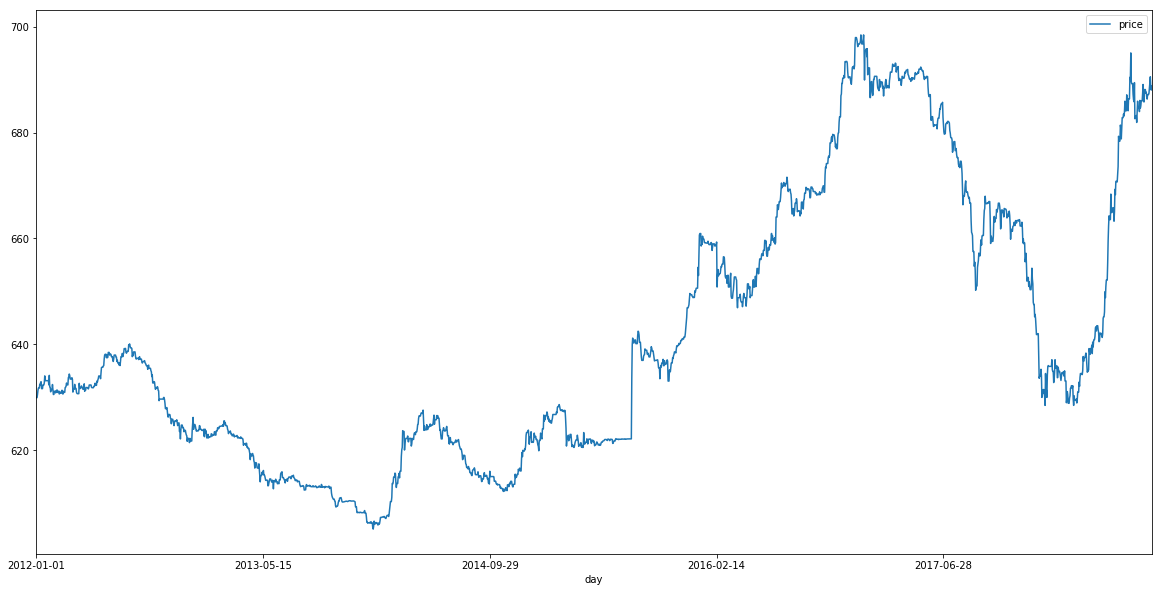

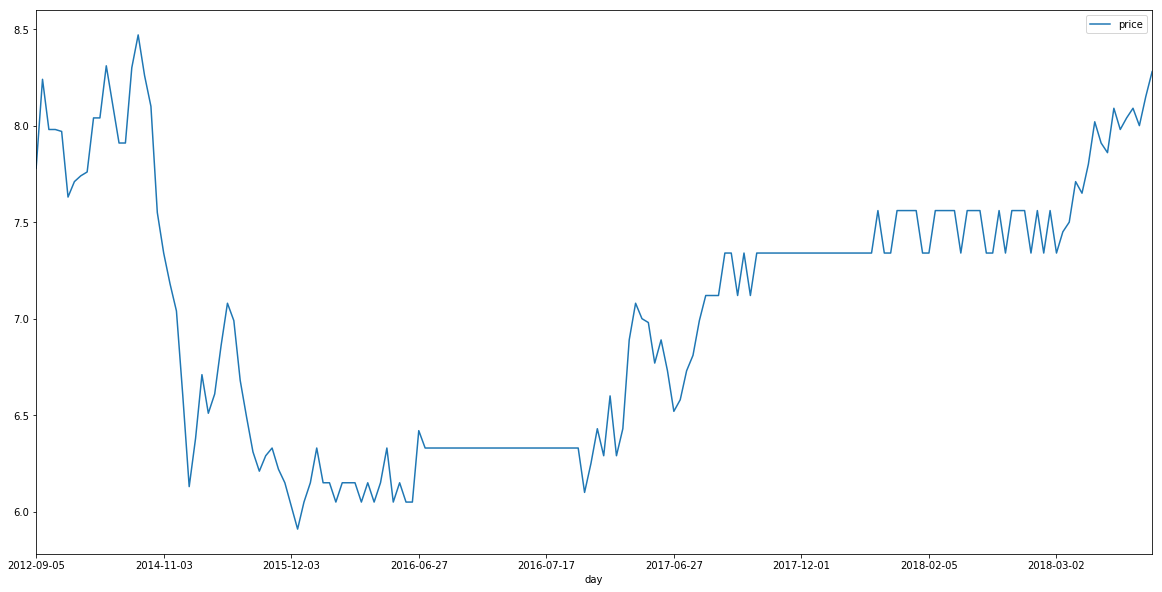

In [19]:
import matplotlib.pylab as plt
import pylab
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

exchange_data.plot('day', 'price')
oil_data.plot('day', 'price')
plt.show()

### 绘制图形
我们需要用不同类型的图形或曲线来描述同样的一个问题。

## 机器学习

### 学习样本和测试样本的准备
需要对数据进行目标输出的标定，也就是对输出值进行定义。    
我们将油价分为10个等级，分别设置为对应的等级数字，学习模型的输出就是对输入对象10个等级的打分

### 模型学习和训练

### 模型校验

### 模型的实践
输入一个汇率值，预测最可能的油价。